In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [13]:
data = pd.read_csv("merged_orders_customers.csv")
data.head()

,Unnamed: 0,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_value,order_month,...,customer_state_x,customer_unique_id_y,customer_zip_code_prefix_y,customer_city_y,customer_state_y,total_payment_value,max_installments,zero_payment_flag,avg_review_score,has_review_text
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19,9,...,RJ,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,72.19,2.0,False,5.0,True
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83,5,...,SP,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,259.83,3.0,False,4.0,False
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87,1,...,MG,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,216.87,5.0,False,5.0,True
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78,8,...,SP,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,25.78,2.0,False,4.0,False
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04,2,...,SP,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,218.04,3.0,False,5.0,True


In [14]:
data.columns = data.columns.str.strip()


In [15]:
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'],
    errors='coerce'
)


In [16]:
data = data.dropna(subset=['order_purchase_timestamp'])
data = data.reset_index(drop=True)


In [17]:
data['year_month'] = data['order_purchase_timestamp'].dt.to_period('M')

monthly_sales = (
   data.groupby('year_month')['total_value']

    .sum()
    .reset_index()
)

monthly_sales['year_month'] = monthly_sales['year_month'].dt.to_timestamp()

monthly_sales.head()


,year_month,total_value
0,2016-09-01,354.75
1,2016-10-01,56808.84
2,2016-12-01,19.62
3,2017-01-01,137188.49
4,2017-02-01,286280.62


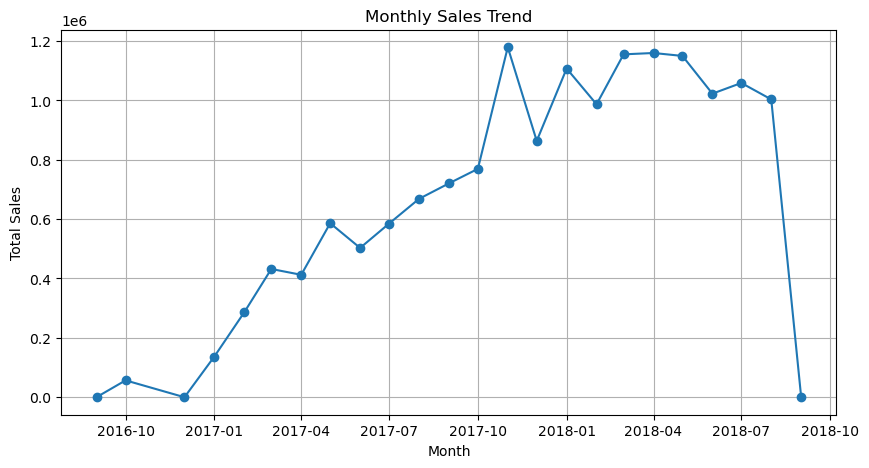

In [18]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['year_month'],
         monthly_sales['total_value'],
         marker='o')

plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid()
plt.show()


In [19]:
monthly_sales['t'] = range(len(monthly_sales))

X = monthly_sales[['t']]
y = monthly_sales['total_value']

lr_model = LinearRegression()
lr_model.fit(X, y)

monthly_sales['predicted_sales'] = lr_model.predict(X)

monthly_sales.head()


,year_month,total_value,t,predicted_sales
0,2016-09-01,354.75,0,177977.640767
1,2016-10-01,56808.84,1,219905.502584
2,2016-12-01,19.62,2,261833.364401
3,2017-01-01,137188.49,3,303761.226219
4,2017-02-01,286280.62,4,345689.088036


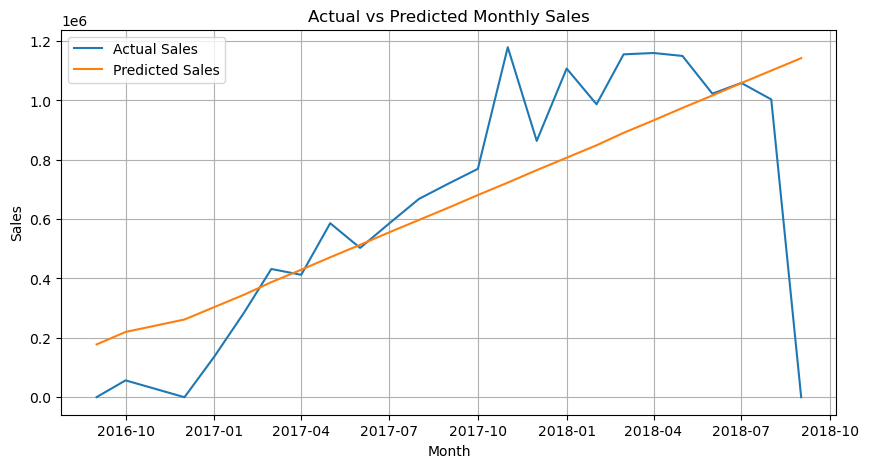

In [20]:
plt.figure(figsize=(10,5))

plt.plot(monthly_sales['year_month'],
         monthly_sales['total_value'],
         label='Actual Sales')

plt.plot(monthly_sales['year_month'],
         monthly_sales['predicted_sales'],
         label='Predicted Sales')

plt.title("Actual vs Predicted Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


In [21]:
future_t = np.arange(len(monthly_sales),
                     len(monthly_sales) + 3).reshape(-1,1)

future_sales = lr_model.predict(future_t)

future_dates = pd.date_range(
    start=monthly_sales['year_month'].max(),
    periods=4,
    freq='M'
)[1:]

forecast_df = pd.DataFrame({
    'Month': future_dates,
    'Forecasted_Sales': future_sales
})

forecast_df


,Month,Forecasted_Sales
0,2018-10-31,1.184246e+06
1,2018-11-30,1.226174e+06
2,2018-12-31,1.268102e+06


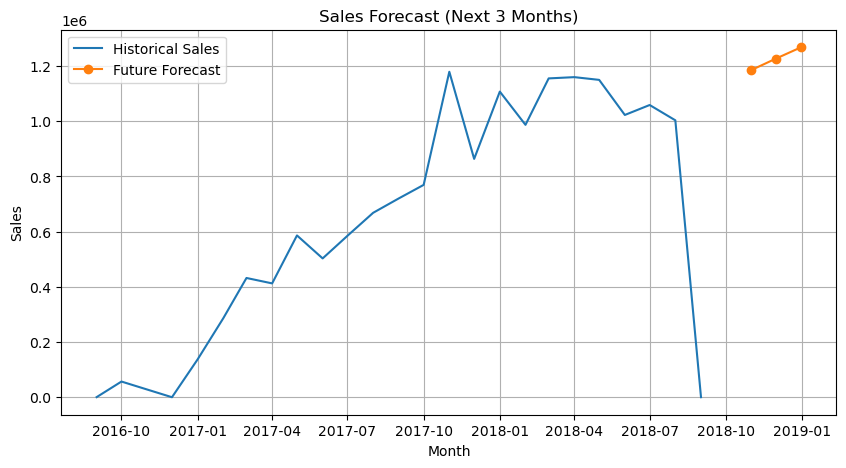

In [22]:
plt.figure(figsize=(10,5))

plt.plot(monthly_sales['year_month'],
         monthly_sales['total_value'],
         label='Historical Sales')

plt.plot(forecast_df['Month'],
         forecast_df['Forecasted_Sales'],
         marker='o',
         label='Future Forecast')

plt.title("Sales Forecast (Next 3 Months)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


In [24]:
monthly_sales.to_csv(
    "monthly_sales_with_predictions.csv",
    index=False
)

In [26]:
forecast_df.to_csv(
    "future_3_month_sales_forecast.csv",
    index=False
)